# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
# logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
# whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
# mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
# redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values.astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values.astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values.astype(int)                    # 1st parameter
redshift    = redshifts.values.astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [9]:
regression_data['X']

array([[ 1.        ,  0.13198   ,  0.01741872, -0.50530075,  0.25532884],
       [ 1.        ,  0.1387    ,  0.01923769, -0.50530075,  0.25532884],
       [ 1.        ,  0.17168   ,  0.02947402, -0.50530075,  0.25532884],
       ...,
       [ 1.        ,  0.20231   ,  0.04092934,  1.57341614,  2.47563836],
       [ 1.        ,  0.20539   ,  0.04218505, -0.50530075,  0.25532884],
       [ 1.        ,  0.18752   ,  0.03516375, -0.50530075,  0.25532884]])

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


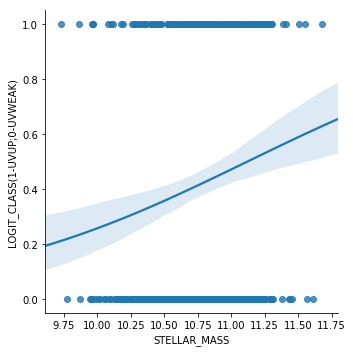

In [10]:
# plt.plot(redshifts, logit_class, '.')
sns.lmplot(x='STELLAR_MASS', y='LOGIT_CLASS(1-UVUP;0-UVWEAK)', data=my_data.iloc[index], logistic=True)
# plt.savefig('../../LargeFilesResults/Model/logistic_seaborn.pdf')
plt.show()

### 2.1 Fit: STAN code 

In [11]:
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
//    real<lower=0> sigma;    // Shared hyperpriors
//    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

//    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
//    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(0, 1);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### 2.2 Fit settings (for STAN)

In [12]:
iterations = 7000
chains     = 2                           # HMC chains
warmup     = 2000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [13]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

### 2.3 Running the fit

In [14]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup,
                  n_jobs=jobs, control=control)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3da39faf6b9ae770b9a8afb67a195ed NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 2.15 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [15]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.04 [min]
--------------------------------------------------


In [16]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_rmshared_revised.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 3.66 [min]
--------------------------------------------------


In [17]:
posteriors = fit_df[fit.flatnames[:25]]
header_posteriors = fit.flatnames[:25]

In [18]:
manual_list = [fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]'],  
               fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]'],
               fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]'],
               fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]'],
               fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']]

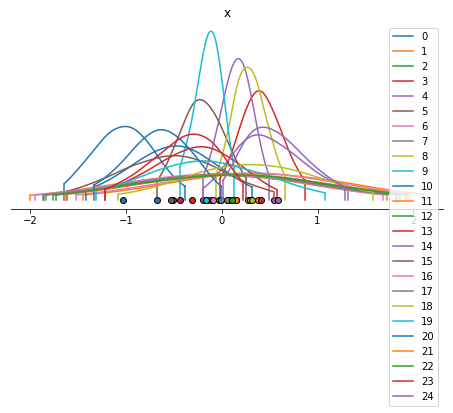

In [19]:
arviz.plot_density(data=manual_list)
plt.show()

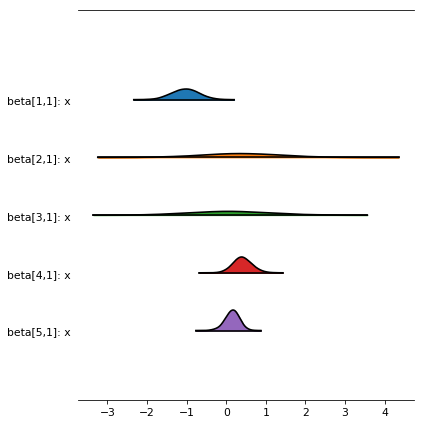

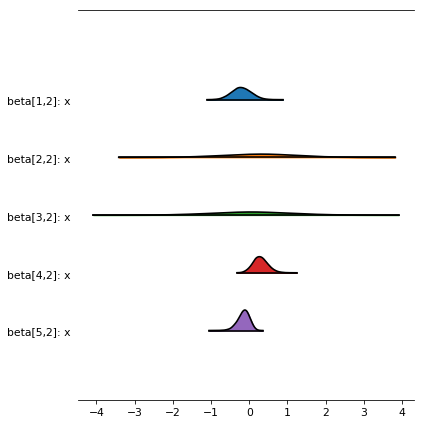

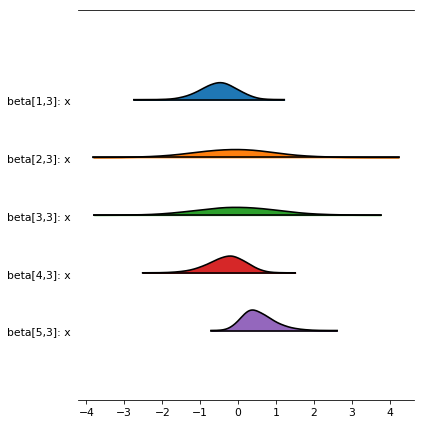

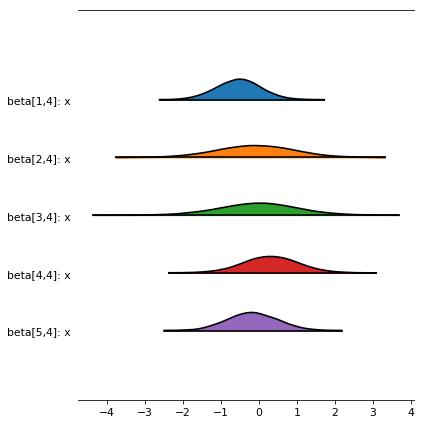

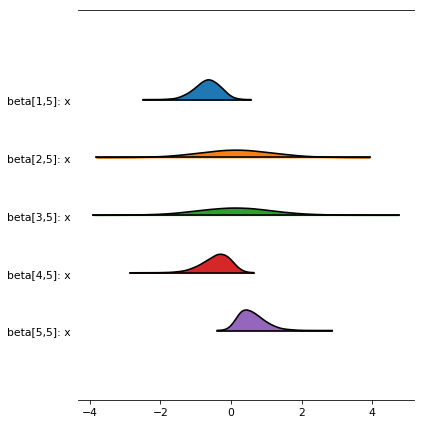

In [20]:
arviz.plot_forest(data=[fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]']], 
                  kind='ridgeplot', model_names=['beta[1,1]', 'beta[2,1]', 'beta[3,1]', 'beta[4,1]', 'beta[5,1]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest01.png', dpi=150, bbox_inches='tight')

arviz.plot_forest(data=[fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]']], 
                  kind='ridgeplot', model_names=['beta[1,2]', 'beta[2,2]', 'beta[3,2]', 'beta[4,2]', 'beta[5,2]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest02.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]']], 
                  kind='ridgeplot', model_names=['beta[1,3]', 'beta[2,3]', 'beta[3,3]', 'beta[4,3]', 'beta[5,3]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest03.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]']], 
                  kind='ridgeplot', model_names=['beta[1,4]', 'beta[2,4]', 'beta[3,4]', 'beta[4,4]', 'beta[5,4]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest04.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']], 
                  kind='ridgeplot', model_names=['beta[1,5]', 'beta[2,5]', 'beta[3,5]', 'beta[4,5]', 'beta[5,5]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest05.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
figsize=(6,3)

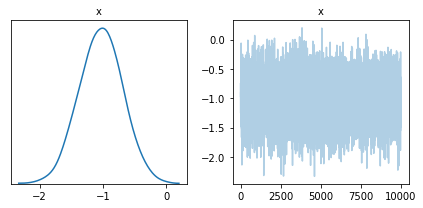

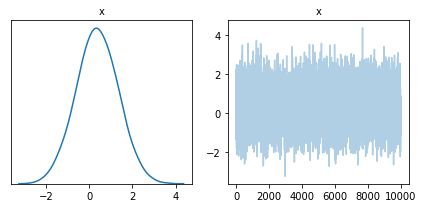

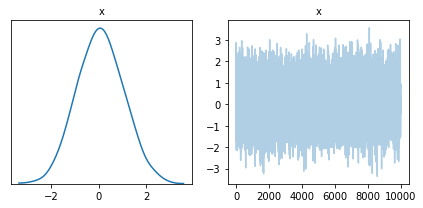

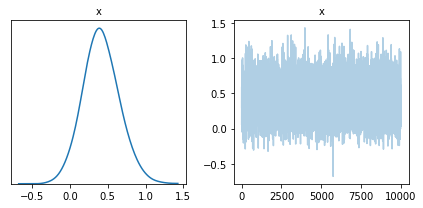

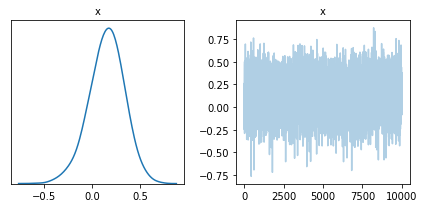

In [22]:
plot = arviz.plot_trace(data=fit['beta[1,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,1]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

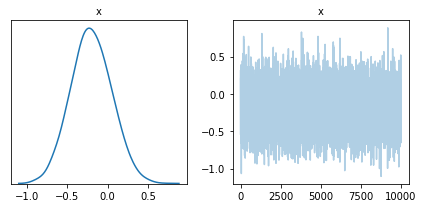

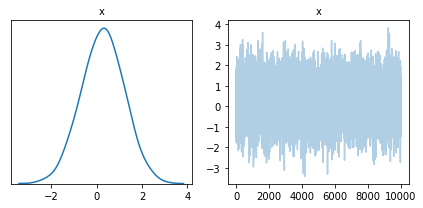

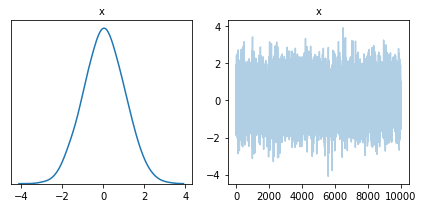

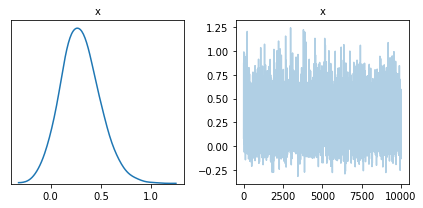

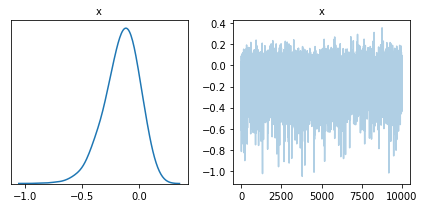

In [23]:
plot = arviz.plot_trace(data=fit['beta[1,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,2]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class02.pdf', bbox_inches='tight')
plt.show()

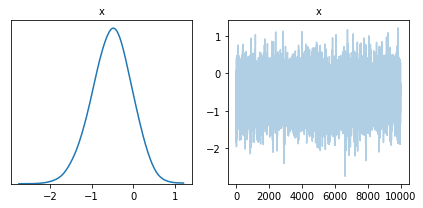

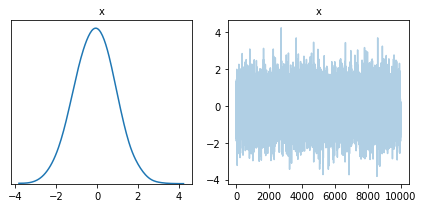

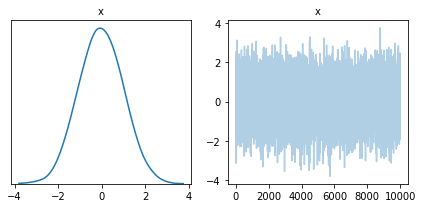

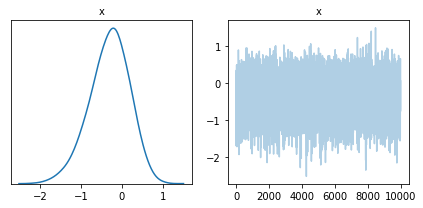

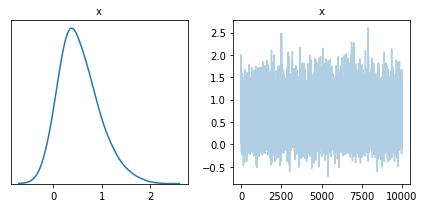

In [24]:
plot = arviz.plot_trace(data=fit['beta[1,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,3]'], figsize=figsize)
plt.tight_layout()
# plt.savefig('../../LargeFilesResults/Model/trace_class03.pdf', bbox_inches='tight')
plt.show()

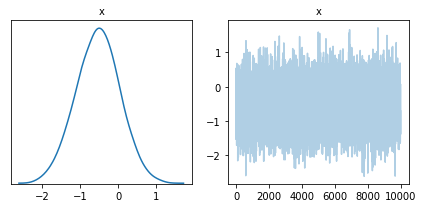

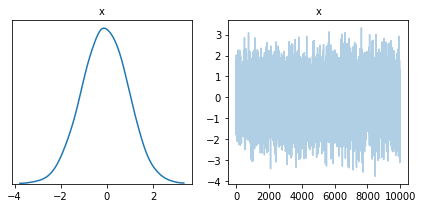

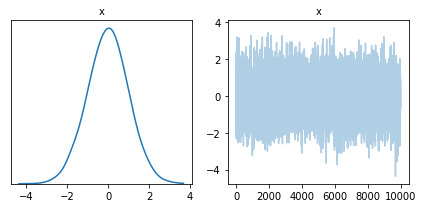

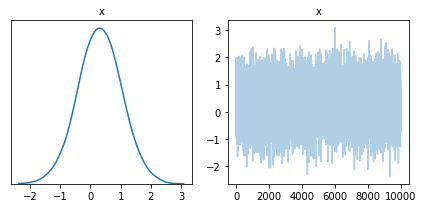

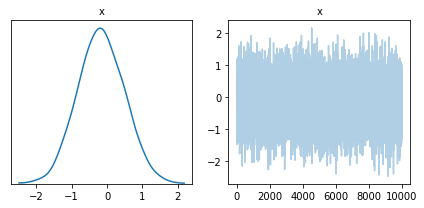

In [25]:
plot = arviz.plot_trace(data=fit['beta[1,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,4]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class04.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

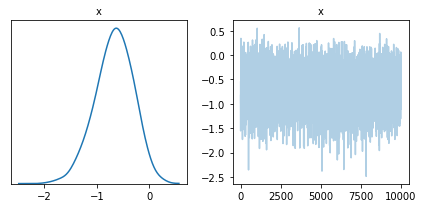

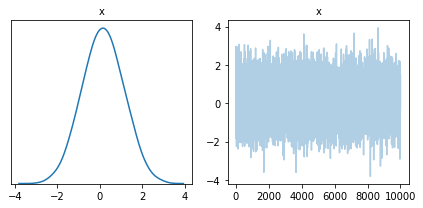

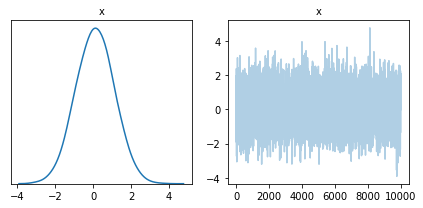

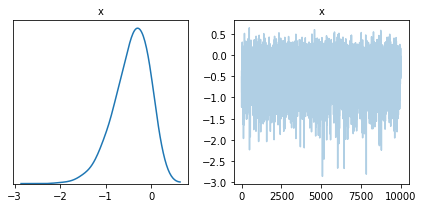

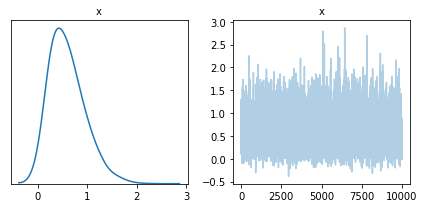

In [26]:
plot = arviz.plot_trace(data=fit['beta[1,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,5]'], figsize=figsize)
# plt.savefig('../../LargeFilesResults/Model/trace_class05.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

### 3.2 Saving the automatic summary from STAN

In [46]:
summary = pystan.stansummary(fit=fit, digits_summary=2)

In [63]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [64]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [68]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp      = recovered_pars
rp_cols = np.vstack((rp, rp, rp, rp, rp))    # for 5 whan classes we must stack these 5x

In [69]:
rp_cols

array([[ 0.06794   ,  9.        ],
       [ 0.08488862,  9.        ],
       [ 0.10183724,  9.        ],
       ...,
       [ 0.52555276, 11.        ],
       [ 0.54250138, 11.        ],
       [ 0.55945   , 11.        ]])

In [70]:
pystan.misc.stansummary??

#### 3.2.2 Checking if the numbers aren't overlaped

In [85]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summary_clean.size):
    if len(summary_clean[i].split())!=11:   # the length of the list must be 11, in which case we connect them directly
        new_summ_temp = np.array(summary_clean[i].split())
        new_summ_temp = np.concatenate((new_summ_temp, ['X']))
        new_summary   = np.vstack((new_summary, new_summ_temp))
#         new_summary   = np.vstack((new_summary, np.concatenate((new_summ_temp, ['X']))))
        print ('new_summary[%d] = ' %i, "%s" %summary_clean[i])
    else:
        new_summ_temp = np.array(summary_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining
print (new_summary[:,0].shape)

new_summary[17] =  beta[3,4]    -0.01  8.5e-3   0.99  -1.96  -0.67-5.3e-3   0.64   1.92  13398    1.0
new_summary[941] =  eta01[17]    -0.97    0.02   1.45  -4.17  -1.84  -0.88-4.6e-3   1.69   8351    1.0
new_summary[1149] =  eta01[225]   -1.19  6.4e-3   0.63  -2.54  -1.58  -1.16  -0.77-6.3e-3   9830    1.0
new_summary[1312] =  eta01[388]   -1.06  4.6e-3   0.54  -2.13  -1.41  -1.06  -0.69-3.9e-3  13948    1.0
new_summary[1459] =  eta01[535]   -0.89  3.7e-3   0.46   -1.8  -1.19  -0.89  -0.59-8.2e-5  15050    1.0
new_summary[1597] =  eta01[673]   -0.64  3.1e-3   0.32  -1.27  -0.86  -0.64  -0.43-3.0e-3  11107    1.0
new_summary[1720] =  eta01[796]   -0.23  2.9e-3   0.34  -0.88  -0.46  -0.24-7.5e-3   0.43  13031    1.0
new_summary[1781] =  eta01[857]  1.1e-3  3.1e-3   0.37  -0.72  -0.25-4.4e-3   0.25   0.75  14559    1.0
new_summary[2852] =  eta02[128]   -1.36  9.6e-3   0.82  -3.21  -1.83  -1.27   -0.8-9.6e-3   7170    1.0
new_summary[2917] =  eta02[193]   -1.09  7.5e-3   0.63  -2.49  -1.4

In [86]:
new_summary[17] =  'beta[3,4]    -0.01  8.5e-3   0.99  -1.96  -0.67 -5.3e-3   0.64   1.92  13398    1.0'
new_summary[941] =  'eta01[17]    -0.97    0.02   1.45  -4.17  -1.84  -0.88 -4.6e-3   1.69   8351    1.0'
new_summary[1149] =  'eta01[225]   -1.19  6.4e-3   0.63  -2.54  -1.58  -1.16  -0.77 -6.3e-3   9830    1.0'
new_summary[1312] =  'eta01[388]   -1.06  4.6e-3   0.54  -2.13  -1.41  -1.06  -0.69 -3.9e-3  13948    1.0'
new_summary[1459] =  'eta01[535]   -0.89  3.7e-3   0.46   -1.8  -1.19  -0.89  -0.59 -8.2e-5  15050    1.0'
new_summary[1597] =  'eta01[673]   -0.64  3.1e-3   0.32  -1.27  -0.86  -0.64  -0.43 -3.0e-3  11107    1.0'
new_summary[1720] =  'eta01[796]   -0.23  2.9e-3   0.34  -0.88  -0.46  -0.24 -7.5e-3   0.43  13031    1.0'
new_summary[1781] =  'eta01[857]  1.1e-3  3.1e-3   0.37  -0.72  -0.25 -4.4e-3   0.25   0.75  14559    1.0'
new_summary[2852] =  'eta02[128]   -1.36  9.6e-3   0.82  -3.21  -1.83  -1.27   -0.8 -9.6e-3   7170    1.0'
new_summary[2917] =  'eta02[193]   -1.09  7.5e-3   0.63  -2.49  -1.45  -1.03  -0.65 -5.6e-3   6980    1.0'
new_summary[2949] =  'eta02[225]   -0.96  6.6e-3   0.55  -2.18  -1.29  -0.92  -0.58 -5.8e-4   6944    1.0'
new_summary[3069] =  'eta02[345]   -0.57  3.2e-3    0.3  -1.19  -0.76  -0.56  -0.36 -6.9e-3   8625    1.0'
new_summary[3143] =  'eta02[419]   -0.33  4.6e-3   0.49  -1.29  -0.66  -0.33 -3.0e-3   0.62  11053    1.0'
new_summary[3178] =  'eta02[454]   -0.33  1.5e-3   0.17  -0.66  -0.44  -0.33  -0.21 -1.1e-3  12820    1.0'
new_summary[3179] =  'eta02[455]   -0.32  1.4e-3   0.16  -0.64  -0.43  -0.32  -0.21 -9.6e-4  13177    1.0'
new_summary[3196] =  'eta02[472]   -0.23  3.0e-3   0.33  -0.89  -0.46  -0.23 -6.3e-3   0.42  12656    1.0'
new_summary[3249] =  'eta02[525]   -0.16  2.1e-3   0.24  -0.62  -0.32  -0.16 -2.9e-3    0.3  12916    1.0'
new_summary[3274] =  'eta02[550]   -0.14  2.0e-3    0.2  -0.53  -0.28  -0.14 -5.6e-3   0.27  10014    1.0'
new_summary[3322] =  'eta02[598] -4.1e-3  4.0e-3   0.46   -0.9  -0.32 -5.5e-3   0.31   0.89  13274    1.0'
new_summary[3323] =  'eta02[599]  1.5e-3  4.2e-3   0.48  -0.94  -0.32 -7.1e-4   0.33   0.94  13260    1.0'
new_summary[3346] =  'eta02[622] -4.2e-3  3.1e-3   0.35  -0.69  -0.24 -7.5e-3   0.23   0.69  12982    1.0'
new_summary[3347] =  'eta02[623]  1.3e-3  3.2e-3   0.37  -0.71  -0.25 -1.5e-3   0.25   0.72  13091    1.0'
new_summary[3371] =  'eta02[647] -4.0e-3  2.6e-3   0.28  -0.54  -0.19 -7.8e-3   0.18   0.56  11620    1.0'
new_summary[3372] =  'eta02[648]  1.3e-3  2.7e-3   0.29  -0.56   -0.2 -1.5e-3    0.2   0.59  11952    1.0'
new_summary[3398] =  'eta02[674]  9.4e-4  2.5e-3   0.25  -0.48  -0.17 -6.3e-3   0.16   0.52  10332    1.0'
new_summary[3399] =  'eta02[675]  6.1e-3  2.5e-3   0.26  -0.49  -0.17 -8.4e-4   0.18   0.54  10714    1.0'
new_summary[3425] =  'eta02[701] -5.6e-5  2.4e-3   0.23  -0.44  -0.16 -4.7e-3   0.15   0.48   9300    1.0'
new_summary[3426] =  'eta02[702]  5.0e-3  2.4e-3   0.24  -0.45  -0.16 -4.0e-4   0.16   0.49   9669    1.0'
new_summary[3452] =  'eta02[728] -7.0e-3  2.5e-3   0.23  -0.44  -0.16 -8.6e-3   0.14   0.46   8768    1.0'
new_summary[3453] =  'eta02[729] -2.0e-3  2.4e-3   0.23  -0.44  -0.16 -4.2e-3   0.15   0.46   9013    1.0'
new_summary[3482] =  'eta02[758] -5.2e-3  2.4e-3   0.23  -0.45  -0.16 -7.7e-3   0.15   0.46   9302    1.0'
new_summary[3483] =  'eta02[759] -1.9e-4  2.4e-3   0.23  -0.44  -0.16 -2.7e-3   0.15   0.46   9548    1.0'
new_summary[3513] =  'eta02[789] -4.6e-3  2.3e-3   0.24  -0.46  -0.17 -6.5e-3   0.15   0.46  10413    1.0'
new_summary[3514] =  'eta02[790]  4.1e-4  2.3e-3   0.24  -0.45  -0.16 -2.2e-3   0.16   0.47  10685    1.0'
new_summary[3545] =  'eta02[821] -5.2e-3  2.2e-3   0.25  -0.48  -0.17 -7.9e-3   0.16   0.48  12138    1.0'
new_summary[3546] =  'eta02[822] -1.3e-4  2.2e-3   0.25  -0.48  -0.17 -1.5e-3   0.17   0.49  12392    1.0'
new_summary[3578] =  'eta02[854] -6.8e-3  2.3e-3   0.27  -0.53   -0.2 -4.5e-3   0.18   0.52  13894    1.0'
new_summary[3612] =  'eta02[888] -9.1e-3  2.7e-3   0.32  -0.63  -0.23 -4.4e-3   0.21   0.61  14407    1.0'
new_summary[4819] =  'eta03[295]    0.74    0.01   1.05  -1.08 -3.7e-3   0.65    1.4   3.05   6873    1.0'
new_summary[4820] =  'eta03[296]    0.74    0.01   1.06   -1.1 -9.7e-3   0.65   1.41   3.07   6912    1.0'
new_summary[4994] =  'eta03[470]   -0.32  3.7e-3   0.47  -1.24  -0.64  -0.33 -7.6e-3   0.57  15882    1.0'
new_summary[4995] =  'eta03[471]   -0.33  3.8e-3   0.48  -1.26  -0.65  -0.33 -1.9e-3   0.59  15877    1.0'
new_summary[5268] =  'eta03[744]   -0.44  6.6e-3   0.64  -1.73  -0.87  -0.43 -5.5e-3    0.8   9555    1.0'
new_summary[6922] =  'eta04[598]   -0.55  8.5e-3    0.8  -2.15  -1.08  -0.55 -3.0e-3   1.02   8963    1.0'
new_summary[6940] =  'eta04[616]   -0.49  8.2e-3   0.72  -1.92  -0.97  -0.49 -8.5e-3    0.9   7559    1.0'
new_summary[6941] =  'eta04[617]   -0.49  8.3e-3   0.72  -1.94  -0.98  -0.49 -8.4e-3   0.92   7633    1.0'
new_summary[6942] =  'eta04[618]    -0.5  8.3e-3   0.73  -1.96  -0.99  -0.49 -5.1e-3   0.93   7712    1.0'
new_summary[6943] =  'eta04[619]    -0.5  8.4e-3   0.74  -1.97  -0.99   -0.5 -1.1e-3   0.95   7797    1.0'
new_summary[8455] =  'eta05[331]    0.37  7.7e-3   0.52   -0.5 -2.6e-3   0.31   0.69   1.54   4584    1.0'
new_summary[8529] =  'eta05[405]  6.6e-4  3.5e-3   0.31   -0.6  -0.21 -8.4e-3   0.21   0.65   7946    1.0'
new_summary[8530] =  'eta05[406]  4.3e-3  3.6e-3   0.32  -0.61  -0.22 -4.9e-3   0.21   0.67   8134    1.0'
new_summary[8531] =  'eta05[407]  8.1e-3  3.7e-3   0.34  -0.63  -0.22 -2.7e-4   0.23   0.69   8309    1.0'
new_summary[8558] =  'eta05[434]   -0.17  2.3e-3   0.25  -0.67  -0.35  -0.18 -4.3e-3   0.32  12402    1.0'
new_summary[8599] =  'eta05[475]   -0.28  3.5e-3   0.42  -1.09  -0.56  -0.28 -3.5e-3   0.54  13992    1.0'
new_summary[8613] =  'eta05[489]   -0.46  2.8e-3   0.24  -0.95  -0.62  -0.46   -0.3 -3.9e-3   7284    1.0'
new_summary[8645] =  'eta05[521]   -0.56  4.0e-3    0.3  -1.17  -0.75  -0.54  -0.35 -5.5e-3   5599    1.0'
new_summary[8676] =  'eta05[552]   -0.63  5.0e-3   0.35  -1.37  -0.84   -0.6  -0.38 -1.5e-3   4984    1.0'
new_summary[8706] =  'eta05[582]   -0.68  5.7e-3   0.39  -1.51  -0.91  -0.65  -0.41 -3.4e-3   4621    1.0'
new_summary[8735] =  'eta05[611]   -0.71  6.2e-3   0.41   -1.6  -0.96  -0.67  -0.42 -4.3e-3   4361    1.0'
new_summary[8755] =  'eta05[631]   -0.74  6.6e-3   0.43  -1.66   -1.0   -0.7  -0.44 -9.1e-3   4170    1.0'
new_summary[8762] =  'eta05[638]   -0.72  6.5e-3   0.42  -1.65  -0.97  -0.68  -0.42 -9.2e-3   4144    1.0'
new_summary[8763] =  'eta05[639]   -0.72  6.5e-3   0.42  -1.64  -0.97  -0.68  -0.42 -5.2e-3   4180    1.0'
new_summary[8904] =  'eta05[780]    -0.4  6.1e-3   0.57  -1.52  -0.77  -0.38 -9.0e-3   0.66   8546    1.0'
new_summary[8928] =  'eta05[804]    -0.3  5.0e-3   0.44  -1.19  -0.59  -0.29 -3.9e-3   0.51   7826    1.0'
new_summary[8944] =  'eta05[820]   -0.21  3.7e-3    0.3  -0.82  -0.41  -0.21 -8.4e-3   0.36   6537    1.0'
new_summary[8945] =  'eta05[821]   -0.21  3.7e-3    0.3  -0.82  -0.41   -0.2 -4.2e-3   0.36   6605    1.0'
new_summary[8983] =  'eta05[859]   -0.01  3.3e-3   0.32  -0.64  -0.24 -8.4e-3   0.21   0.63   9923    1.0'
new_summary[8984] =  'eta05[860] -7.2e-3  3.3e-3   0.33  -0.66  -0.24 -4.9e-3   0.22   0.65  10157    1.0'
new_summary[8985] =  'eta05[861] -3.3e-3  3.4e-3   0.35  -0.68  -0.24 -6.8e-4   0.23   0.67  10395    1.0'

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [87]:
parameters = new_summary[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print (new_summary[pnew_idxs,:].shape, rp_cols.shape)
model_results    = np.column_stack((new_summary[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.index = model_results_df['parameter']
model_results_df = model_results_df.drop(columns='parameter', axis=1)
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summary_rmshared_revised.csv', header=True, index=True)

(4500, 11) (4500, 2)


In [88]:
model_results_df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,Z,LOG_STELLAR_MASS
parameter,,,,,,,,,,,,
prob01[1],0.32,2.2e-3,0.23,0.01,0.12,0.27,0.47,0.82,10672,1.0,0.06794,9.0
prob01[2],0.32,2.2e-3,0.23,0.01,0.13,0.27,0.47,0.82,10624,1.0,0.08488862068965516,9.0
prob01[3],0.32,2.2e-3,0.23,0.01,0.13,0.27,0.48,0.82,10573,1.0,0.10183724137931034,9.0
prob01[4],0.32,2.2e-3,0.23,0.01,0.13,0.28,0.48,0.83,10518,1.0,0.11878586206896552,9.0
prob01[5],0.32,2.2e-3,0.23,0.01,0.13,0.28,0.48,0.83,10460,1.0,0.13573448275862068,9.0
prob01[6],0.32,2.2e-3,0.23,0.01,0.13,0.28,0.48,0.83,10403,1.0,0.15268310344827585,9.0
prob01[7],0.32,2.3e-3,0.23,0.01,0.13,0.28,0.48,0.83,10351,1.0,0.16963172413793104,9.0
prob01[8],0.32,2.3e-3,0.23,0.01,0.13,0.28,0.48,0.83,10296,1.0,0.1865803448275862,9.0
prob01[9],0.33,2.3e-3,0.23,0.02,0.13,0.28,0.48,0.83,10240,1.0,0.20352896551724137,9.0


In [89]:
posteriors = fit_df[fit.flatnames[:25]]

In [90]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1,1]', 'beta[2,1]', 'beta[3,1]',
       'beta[4,1]', 'beta[5,1]', 'beta[1,2]', 'beta[2,2]',
       ...
       'eta05[898]', 'eta05[899]', 'eta05[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=9035)

In [91]:
fit_df['treedepth__'].describe()

count    10000.000000
mean         5.402500
std          0.504895
min          4.000000
25%          5.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: treedepth__, dtype: float64

In [92]:
fit_df['n_leapfrog__'].describe()

count    10000.000000
mean        49.953600
std         17.643905
min         15.000000
25%         31.000000
50%         63.000000
75%         63.000000
max        191.000000
Name: n_leapfrog__, dtype: float64

In [93]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_rmshared_revised.csv', index=False)

In [94]:
posteriors

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[4,2]","beta[5,2]",...,"beta[1,4]","beta[2,4]","beta[3,4]","beta[4,4]","beta[5,4]","beta[1,5]","beta[2,5]","beta[3,5]","beta[4,5]","beta[5,5]"
0,-1.138602,0.311533,1.445701,-0.007941,0.358873,-0.717833,0.902594,0.021808,-0.143929,0.158225,...,-0.114734,-0.968028,0.957840,0.151527,0.396661,-0.357687,0.420179,-0.667599,0.001885,0.015635
1,-1.300240,0.842897,0.548052,0.615832,0.318104,-0.059229,-0.027283,0.148234,0.496065,-0.311913,...,-0.575802,0.825850,0.098259,0.587545,-0.676117,-1.212589,0.143870,1.012336,-0.938883,1.119355
2,-1.309243,-0.143137,0.021571,0.469083,0.280511,0.130950,0.080584,0.353475,0.659082,-0.358758,...,-1.332969,1.210279,-0.331257,-0.068703,0.170433,-1.046730,0.606312,0.635143,-0.501437,0.691489
3,-0.734131,0.049531,0.180026,0.376260,-0.039356,-0.071871,0.102649,-0.312815,0.178697,-0.194416,...,0.263648,-1.498409,-0.337565,0.438419,-0.695967,-0.719339,0.321244,-0.604387,-0.282713,0.490568
4,-1.344217,-0.642302,0.207415,0.351943,0.315942,-0.201867,-0.160461,0.089896,0.439075,-0.073158,...,-1.319804,0.437064,0.961962,-0.638687,0.434877,-0.736756,0.124643,1.232554,-0.314630,0.593604
5,-0.814590,-0.088456,0.173928,0.380835,0.259947,-0.019098,0.575484,-0.848011,0.543518,-0.092174,...,0.414129,-1.595875,0.127986,0.980231,-0.628532,-0.416839,0.519046,-0.825583,-0.095409,0.284228
6,-1.366202,0.768667,-0.044841,0.434136,0.102105,-0.425279,-0.361081,0.006629,0.051996,-0.039955,...,-1.030564,0.626422,0.365789,-0.196544,-0.139799,-1.006002,0.015954,0.968725,-1.028455,0.994713
7,-0.883119,-0.797413,1.047218,0.273751,0.115177,-0.064470,0.332541,-0.349227,0.373625,-0.342089,...,0.350660,-0.122316,-0.524569,0.605214,-1.281713,-0.694814,0.577674,-0.422240,-0.419486,0.726292
8,-1.734888,1.910918,-0.522238,0.367822,0.237460,-0.224982,0.148256,0.254945,0.390649,-0.172212,...,-0.572560,-0.295620,0.569584,-0.330156,-0.306268,-0.660014,1.059910,0.452379,-0.318340,0.286902
9,-0.437719,-0.897316,0.377882,0.219445,0.175562,-0.442660,0.462352,0.398925,0.281316,0.016377,...,-0.124035,0.637268,-0.325235,0.452901,-0.099070,-0.294286,-0.290324,0.233768,-0.457639,0.441087


In [95]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [96]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [97]:
pystan.check_hmc_diagnostics??

In [98]:
model_results_df['Rhat'].max()

'1.0'

In [99]:
model_results_df['Rhat'].min()

'1.0'